# Statistics in `cytoflow`

One of the most powerful concepts in `cytoflow` is that it makes it easy to summarize your data, then track how those summaries change as your experimental variables change.  This notebook demonstrates several different modules that create and plot statistics.

---

Import the `cytoflow` module.

In [1]:
import cytoflow as flow

# if your figures are too big or too small, you can scale them by changing matplotlib's DPI
import matplotlib
matplotlib.rc('figure', dpi = 160)

We use the same data set as the **Yeast Dose Response** example notebook, with one variant: we load each tube three times, grabbing only 100 events from each.

In [2]:
inputs = {
    "Yeast_B1_B01.fcs" : 5.0,
    "Yeast_B2_B02.fcs" : 3.75,
    "Yeast_B3_B03.fcs" : 2.8125,
    "Yeast_B4_B04.fcs" : 2.109,
    "Yeast_B5_B05.fcs" : 1.5820,
    "Yeast_B6_B06.fcs" : 1.1865,
    "Yeast_B7_B07.fcs" : 0.8899,
    "Yeast_B8_B08.fcs" : 0.6674,
    "Yeast_B9_B09.fcs" : 0.5,
    "Yeast_B10_B10.fcs" : 0.3754,
    "Yeast_B11_B11.fcs" : 0.2816,
    "Yeast_B12_B12.fcs" : 0.2112,
    "Yeast_C1_C01.fcs" : 0.1584,
    "Yeast_C2_C02.fcs" : 0.1188,
    "Yeast_C3_C03.fcs" : 0.0892,
    "Yeast_C4_C04.fcs" : 0.0668,
    "Yeast_C5_C05.fcs" : 0.05,
    "Yeast_C6_C06.fcs" : 0.0376,
    "Yeast_C7_C07.fcs" : 0.0282,
    "Yeast_C8_C08.fcs" : 0.0211,
    "Yeast_C9_C09.fcs" : 0.0159
}

tubes = []
for filename, ip in inputs.items():
    tubes.append(flow.Tube(file = "data/" + filename, conditions = {'IP' : ip, 'Replicate' : 1}))
    tubes.append(flow.Tube(file = "data/" + filename, conditions = {'IP' : ip, 'Replicate' : 2}))
    tubes.append(flow.Tube(file = "data/" + filename, conditions = {'IP' : ip, 'Replicate' : 3}))

    
ex = flow.ImportOp(conditions = {'IP' : "float", "Replicate" : "int"},
                   tubes = tubes,
                   events = 100).apply()

In `cytoflow`, a *statistic* is a value that summarizes something about some data.  `cytoflow` makes it easy to compute statistics for various subsets.  For example, if we expect the geometric mean of `FITC-A` channel to change as the `IP` variable changes, we can compute the geometric mean of the `FITC-A` channel of each different `IP` condition with the `ChannelStatisticOp` operation:

In [3]:
op = flow.ChannelStatisticOp(name = "ByIP",
                             by = ["IP"],
                             channel = "FITC-A",
                             function = flow.geom_mean)
ex2 = op.apply(ex)

This operation splits the data set by different values of `IP`, then applies the function `flow.geom_mean` to the `FITC-A` channel in each subset. The result is stored in the `statistics` attribute of an `Experiment`. The `statistics` attribute is a dictionary whose keys are the *names* of the operations that added the statistics:

In [4]:
ex2.statistics.keys()

dict_keys(['ByIP'])

The value of each entry in `Experiment.statistics` is a `pandas.DataFrame` whose index is all the subsets for which the statistic was computed, and the contents are the values of the statstic itself.

In [5]:
ex2.statistics['ByIP']

,FITC-A
IP,
0.0159,101.299847
0.0211,138.550595
0.0282,166.007108
0.0376,188.598209
0.0500,248.470114
0.0668,418.084799
0.0892,659.437078
0.1188,889.045693
0.1584,1277.281273


We can also specify multiple variables to break data set into.  In the example above, `Statistics1DOp` lumps all events with the same value of `IP` together, but each amount of `IP` actually has three values of `Replicate` as well.  Let's apply `geom_mean` to each unique combination of `IP` and `Replicate`:

In [6]:
op = flow.ChannelStatisticOp(name = "ByIP",
                             by = ["IP", "Replicate"],
                             channel = "FITC-A",
                             function = flow.geom_mean)
ex2 = op.apply(ex)
ex2.statistics["ByIP"][0:12]

FITC-A
IP     Replicate            
0.0159 1          101.690138
       2          103.931758
       3           98.355638
0.0211 1          139.620182
       2          142.520679
       3          133.659276
0.0282 1          173.949858
       2          150.902743
       3          174.284529
0.0376 1          179.078378
       2          183.715016
       3          203.903596

Note that the `pandas.DataFrame` now has a `MultiIndex`: there are values for each unique combination of `IP` and `Replicate`.

---

Now that we have computed a statistic, we can plot it with one of the statistics views.  We can use a bar chart:

In [7]:
flow.BarChartView(statistic = "ByIP",
                  feature = "FITC-A",
                  variable = "IP").plot(ex2)

CytoflowViewError: ('plot_name', "You must use facets ['Replicate'] in either the plot variables or the plot name. Possible plot names: [1, 2, 3]")

Oops!  We forgot to specify how to plot the different `Replicate`s.  Each index of a statistic must be specified as either a variable or a facet of the plot, like so:

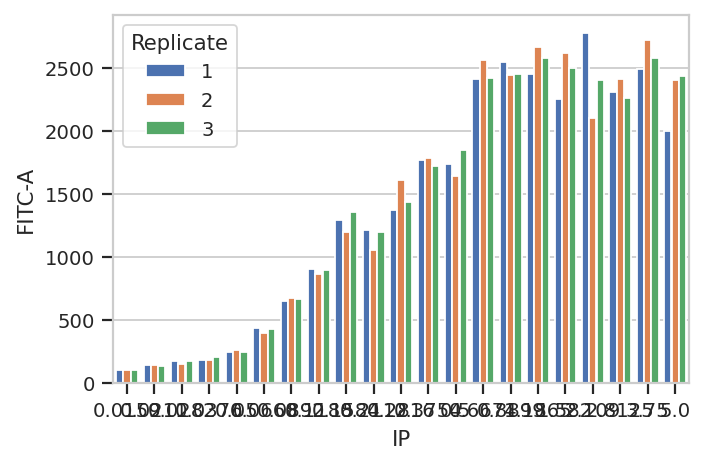

In [8]:
flow.BarChartView(statistic = "ByIP",
                  feature = "FITC-A",
                  variable = "IP",
                  huefacet = "Replicate").plot(ex2)

Note that because a statistic can contain multiple columns, we have to specify which one of them to plot. Taking a term from machine learning, `cytoflow` calls each column of a statistic a `feature`. Thus, `feature = "FITC-A"` tells the `BarChartView` to plot the `FITC-A` column of the statistic. By default, `ChannelStatisticOp` creates a statistic with one feature, named the same as the channel the function was applied to. However, if your function returns a `pandas.Series`, the row names of the series become the column names.

---

A quick aside - sometimes you get ugly axes because of overlapping labels.  In this case, we want a wider plot.  While we can directly specify the height of a plot, we can't directly specify its width, only its aspect ratio (the ratio of the width to the height.)  `cytoflow` defaults to 1.5; in this case, let's widen it out to 4.  If this results in a plot that's wider than your browser, the Jupyter notebook will scale it down for you.

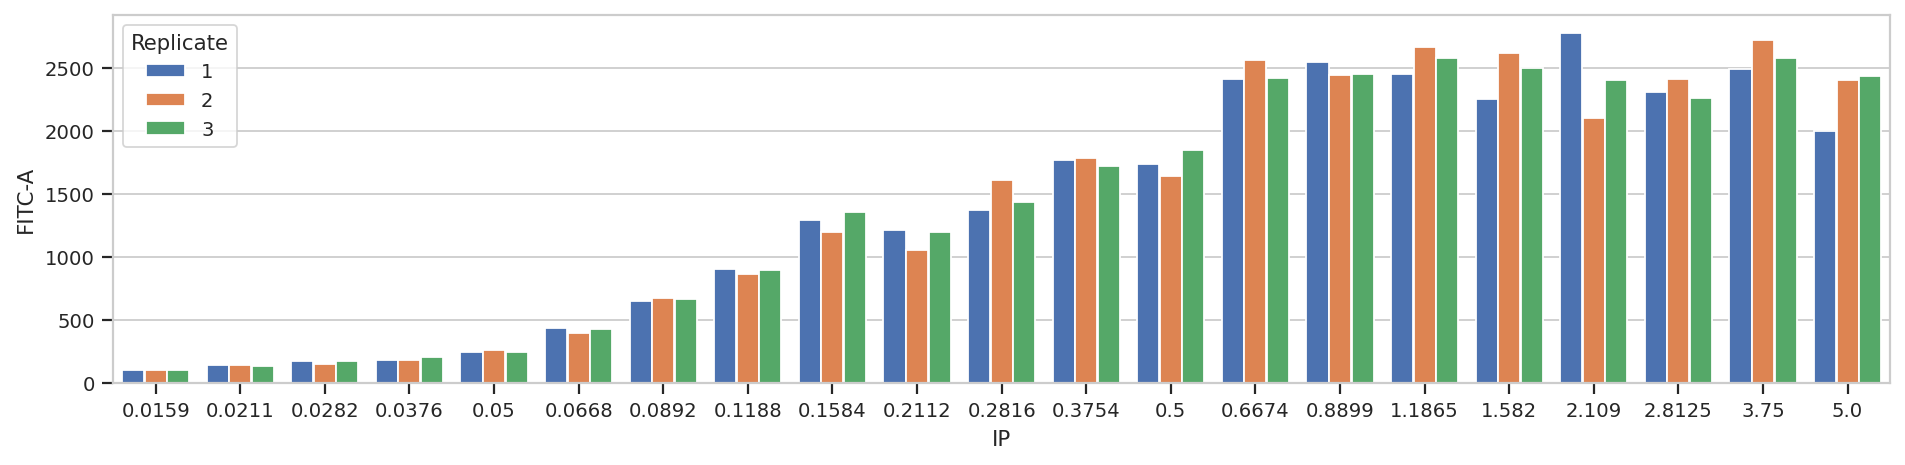

In [9]:
flow.BarChartView(statistic = "ByIP",
                  feature = "FITC-A",
                  variable = "IP",
                  huefacet = "Replicate").plot(ex2, aspect = 4)

Bar charts are really best for categorical variables (with a modest number of categories.)  Let's do a line chart instead:

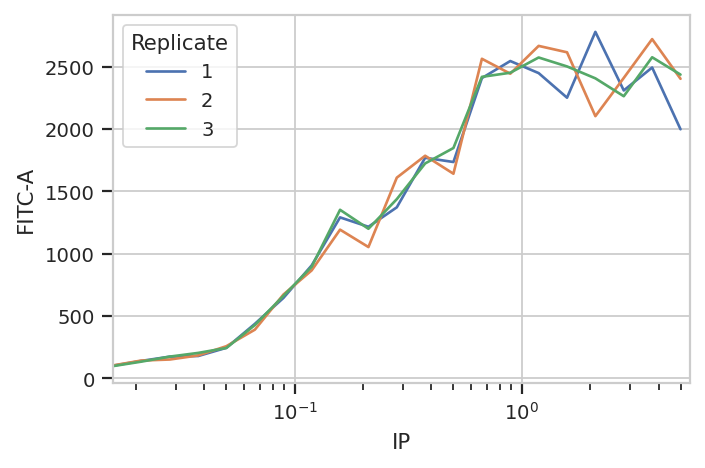

In [10]:
flow.Stats1DView(statistic = "ByIP",
                 feature = "FITC-A",
                 variable = "IP",
                 variable_scale = 'log',
                 huefacet = "Replicate").plot(ex2)

1D and 2D statistics views can also plot error bars; the high and low values must be features in the *same statistic*, which is pretty easy to do if the function you use in `ChannelStatisticOp` returns a `pandas.Series`. Here's an example that uses a lambda expression
to avoid defining a whole new function, computing the geometric mean and standard deviation of each subset:

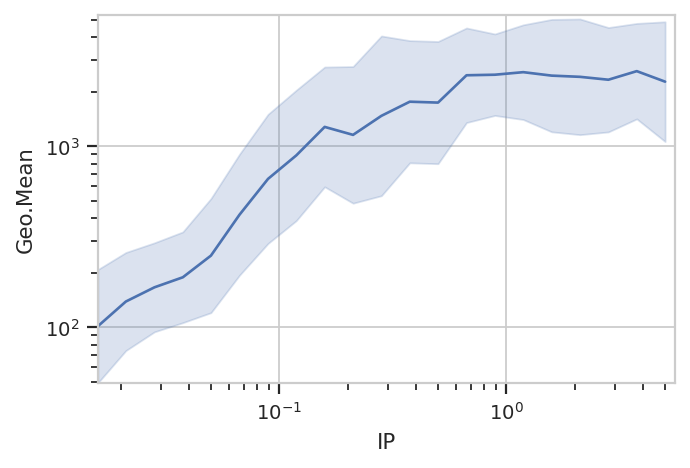

In [11]:
# While an arithmetic SD is usually plotted plus-or-minus the arithmetic mean, 
# a *geometric* SD is usually plotted (on a log scale!) multiplied-or-divided by the 
# geometric mean.  the function geom_sd_range is a convenience function that does this.

import pandas as pd
ex2 = flow.ChannelStatisticOp(name = "ByIP",
                              by = ["IP"],
                              channel = "FITC-A",
                              function = lambda x: pd.Series({"Geo.Mean" : flow.geom_mean(x),
                                                              "*SD" : flow.geom_mean(x) * flow.geom_sd(x),
                                                              "/SD" : flow.geom_mean(x) / flow.geom_sd(x)})).apply(ex)

flow.Stats1DView(statistic = "ByIP",
                 variable = "IP",
                 variable_scale = "log",
                 feature = "Geo.Mean",
                 scale = "log",
                 error_low = "/SD",
                 error_high = "*SD").plot(ex2, shade_error = True)

The plot above shows how one statistic varies (on the Y axis) as a variable changes on the X axis. It also demonstrates that we can control the visual aspects of the plot by the parameters passed to `plot()`. The rule-of-thumb to remember is that the view object's attributes determine *what* is plotted; the parameters passed to *plot()* determine *how* it is plotted. We pass many of these parameters straight through to the underlying `seaborn` and `matplotlib` plotting functions; see the documentation of each view for details.

---

We can also plot two features against eachother, one on the X axis and one on the Y axis.  For example, we can ask if the geometric standard deviation varies as the geometric mean changes:

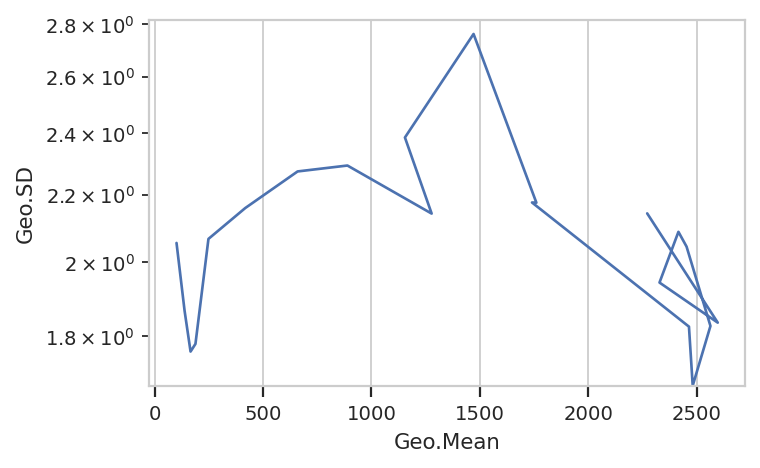

In [12]:
ex2 = flow.ChannelStatisticOp(name = "ByIP",
                              by = ["IP"],
                              channel = "FITC-A",
                              function = lambda x: pd.Series({"Geo.Mean" : flow.geom_mean(x),
                                                              "Geo.SD" : flow.geom_sd(x)})).apply(ex)

flow.Stats2DView(statistic = "ByIP",
                 variable = "IP",
                 xfeature = "Geo.Mean",
                 yfeature = "Geo.SD",
                 yscale = "log").plot(ex2)

Nope, guess not.  See the **TASBE Calibrated Flow Cytometry** notebook for more examples of 1D and 2D statistics views.

---

## Transforming statistics

In addition to making statistics by applying summary functions to data, you can also apply functions to other statistics.  For example, a common question is "What percentage of my events are in a particular gate?"  We could, for instance, ask what percentage of events are above 1000 in the `FITC-A` channel, and how that varies by amount of `IP`. We start by defining a *threshold* gate with `ThresholdOp`:

In [13]:
thresh = flow.ThresholdOp(name = "Above1000",
                          channel = "FITC-A",
                          threshold = 1000)
ex2 = thresh.apply(ex)

Now, the `Experiment` has a condition named `Above1000` that is `True` or `False` depending on whether that event's `FITC-A` channel is greater than 1000.  Next, we compute the total number of events in each subset with a unique combination of `Above1000` and `IP`:

In [14]:
ex3 = flow.ChannelStatisticOp(name = "Above1000",
                              by = ["Above1000", "IP"],
                              channel = "FITC-A",
                              function = len,
                              fill = 0).apply(ex2)
ex3.statistics["Above1000"]

/home/brian/src/cytoflow/cytoflow/operations/channel_stat.py:217: CytoflowOpWarning: No events for category ['Above1000=True', 'IP=0.0376']
/home/brian/src/cytoflow/cytoflow/operations/channel_stat.py:217: CytoflowOpWarning: No events for category ['Above1000=True', 'IP=0.0159']


FITC-A
Above1000 IP            
False     0.0159   300.0
          0.0211   299.0
          0.0282   299.0
          0.0376   300.0
          0.0500   293.0
          0.0668   262.0
          0.0892   195.0
          0.1188   150.0
          0.1584    95.0
          0.2112   108.0
          0.2816    72.0
          0.3754    63.0
          0.5000    55.0
          0.6674    19.0
          0.8899    13.0
          1.1865    14.0
          1.5820    26.0
          2.1090    28.0
          2.8125    30.0
          3.7500    20.0
          5.0000    34.0
True      0.0159     0.0
          0.0211     1.0
          0.0282     1.0
          0.0376     0.0
          0.0500     7.0
          0.0668    38.0
          0.0892   105.0
          0.1188   150.0
          0.1584   205.0
          0.2112   192.0
          0.2816   228.0
          0.3754   237.0
          0.5000   245.0
          0.6674   281.0
          0.8899   287.0
          1.1865   286.0
          1.5820   274.0
          2.1090   272.0
          2.8125   270.0
          3.7500   280.0
          5.0000   266.0

Note the warning -- there are a few groups that don't have *any* events. By default, `cytoflow` gives you an error if this is the case. However, if you set the `fill` attribute of the `ChannelStatisticsOp`, it will fill that value in for you instead. 

---

And now we compute the proportion of `Above1000 == True` for each value of `IP`.  `TransformStatisticOp` applies a function to subsets of a statistic -- the function must take a single `pandas.Series` parameter and it may return either a single `float` value, in which case the operation is a reduction, or it may return a `pandas.Series` with the same index as the passed series, in which case it is a transformation. Here, we're applying a `lambda` function to convert each `IP` subset from length into proportion.

In [15]:
import pandas as pd

ex4 = flow.TransformStatisticOp(name = "PropAbove1000",
                                statistic = "Above1000",
                                by = ["IP"],
                                function = lambda a: a / a.sum()).apply(ex3)

ex4.statistics["PropAbove1000"][0:8]

FITC-A
IP     Above1000          
0.0159 False      1.000000
       True       0.000000
0.0211 False      0.996667
       True       0.003333
0.0282 False      0.996667
       True       0.003333
0.0376 False      1.000000
       True       0.000000

Now we can plot the new statistic.

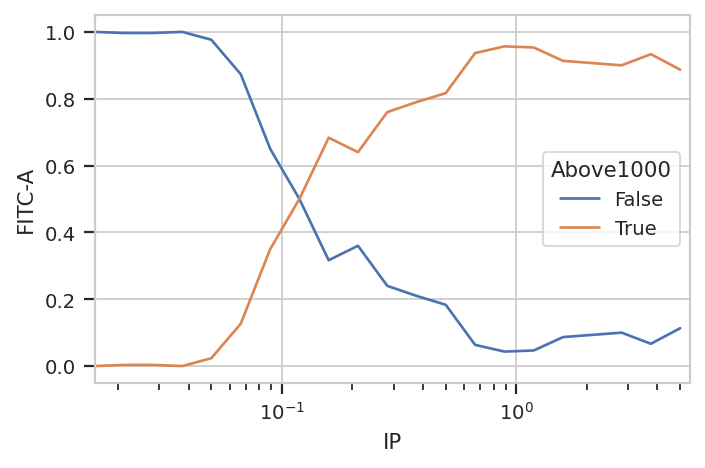

In [16]:
flow.Stats1DView(statistic = "PropAbove1000",
                 feature = "FITC-A",
                 variable = "IP",
                 variable_scale = "log",
                 huefacet = "Above1000").plot(ex4)

Note that be default we get all the values in the statistic; in this case, it's both the proportion that's above 1000 (`True`) and the proportion that is below it (`False`).  We can set a `subset` attribute to the `Stats1DView` to look at just one or the other. This is passed directly `pandas.DataFrame.query()` -- essentialy, it is a Python expression that evaluates to `True` or `False` for each row. Only the events where the expresison is `True` are kept.

/home/brian/src/cytoflow/cytoflow/views/base_views.py:848: CytoflowViewWarning: Only one value for level Above1000; dropping it.


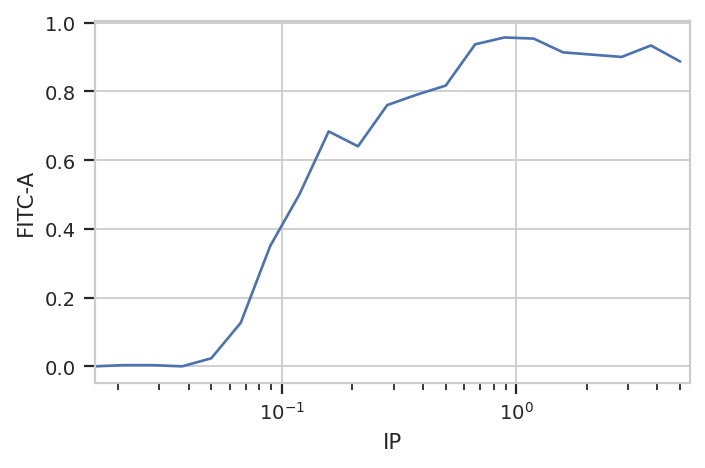

In [17]:
flow.Stats1DView(statistic = "PropAbove1000",
                 feature = "FITC-A",
                 variable = "IP",
                 variable_scale = "log",
                 subset = "Above1000 == True").plot(ex4)

Note the warning.  Because the index level `Above1000` is always `True` in this subset, it gets dropped from the index.  As a result, we don't have to specify it as a variable or facet anywhere.

---

## Statistics from data-driven modules

One of the most exciting aspects of statistics in `cytoflow` is that other data-driven modules can add them to an `Experiment`, too. Let's look at a quick example, starting by re-loading the entire yeast induction dataset:

In [18]:
import cytoflow as flow
inputs = {
    "Yeast_B1_B01.fcs" : 5.0,
    "Yeast_B2_B02.fcs" : 3.75,
    "Yeast_B3_B03.fcs" : 2.8125,
    "Yeast_B4_B04.fcs" : 2.109,
    "Yeast_B5_B05.fcs" : 1.5820,
    "Yeast_B6_B06.fcs" : 1.1865,
    "Yeast_B7_B07.fcs" : 0.8899,
    "Yeast_B8_B08.fcs" : 0.6674,
    "Yeast_B9_B09.fcs" : 0.5,
    "Yeast_B10_B10.fcs" : 0.3754,
    "Yeast_B11_B11.fcs" : 0.2816,
    "Yeast_B12_B12.fcs" : 0.2112,
    "Yeast_C1_C01.fcs" : 0.1584,
    "Yeast_C2_C02.fcs" : 0.1188,
    "Yeast_C3_C03.fcs" : 0.0892,
    "Yeast_C4_C04.fcs" : 0.0668,
    "Yeast_C5_C05.fcs" : 0.05,
    "Yeast_C6_C06.fcs" : 0.0376,
    "Yeast_C7_C07.fcs" : 0.0282,
    "Yeast_C8_C08.fcs" : 0.0211,
    "Yeast_C9_C09.fcs" : 0.0159
}

tubes = []
for filename, ip in inputs.items():
    tubes.append(flow.Tube(file = "data/" + filename, conditions = {'IP' : ip}))

    
ex = flow.ImportOp(conditions = {'IP' : "float"},
                   tubes = tubes).apply()

For this example, we'll use the `GaussianMixtureOp` operation. It adds a statistic for each component of the mixture model it fits, containing the mean, standard deviation, and a few other statistics (see the docs for details):

In [19]:
op = flow.GaussianMixtureOp(name = "Gauss",
                            channels = ["FITC-A"],
                            scale = {"FITC-A" : 'logicle'},
                            by = ["IP"],
                            num_components = 1)
op.estimate(ex)
ex2 = op.apply(ex)
ex2.statistics["Gauss"]

,FITC-A Mean,FITC-A SD,FITC-A Interval Low,FITC-A Interval High
IP,,,,
0.0159,114.867593,6.044478,56.944599,224.178352
0.0211,146.760865,3.206172,80.365347,265.784241
0.0282,161.831942,3.483374,88.275085,295.421818
0.0376,188.241811,4.164093,101.184975,350.418214
0.0500,252.533895,6.484476,127.952042,502.065649
0.0668,415.359435,9.197695,195.235139,894.571209
0.0892,675.335896,9.728315,310.618328,1484.661773
0.1188,976.574632,10.505229,437.615067,2200.01757
0.1584,1212.127491,10.465049,542.10246,2732.441099


Many operations also have a "default" view which provides more information about how they ran. For example, the `GaussianMixtureOp` class has a `default_view()` member that returns a view which plots the underlying data as well as the gaussian curves that were fit:

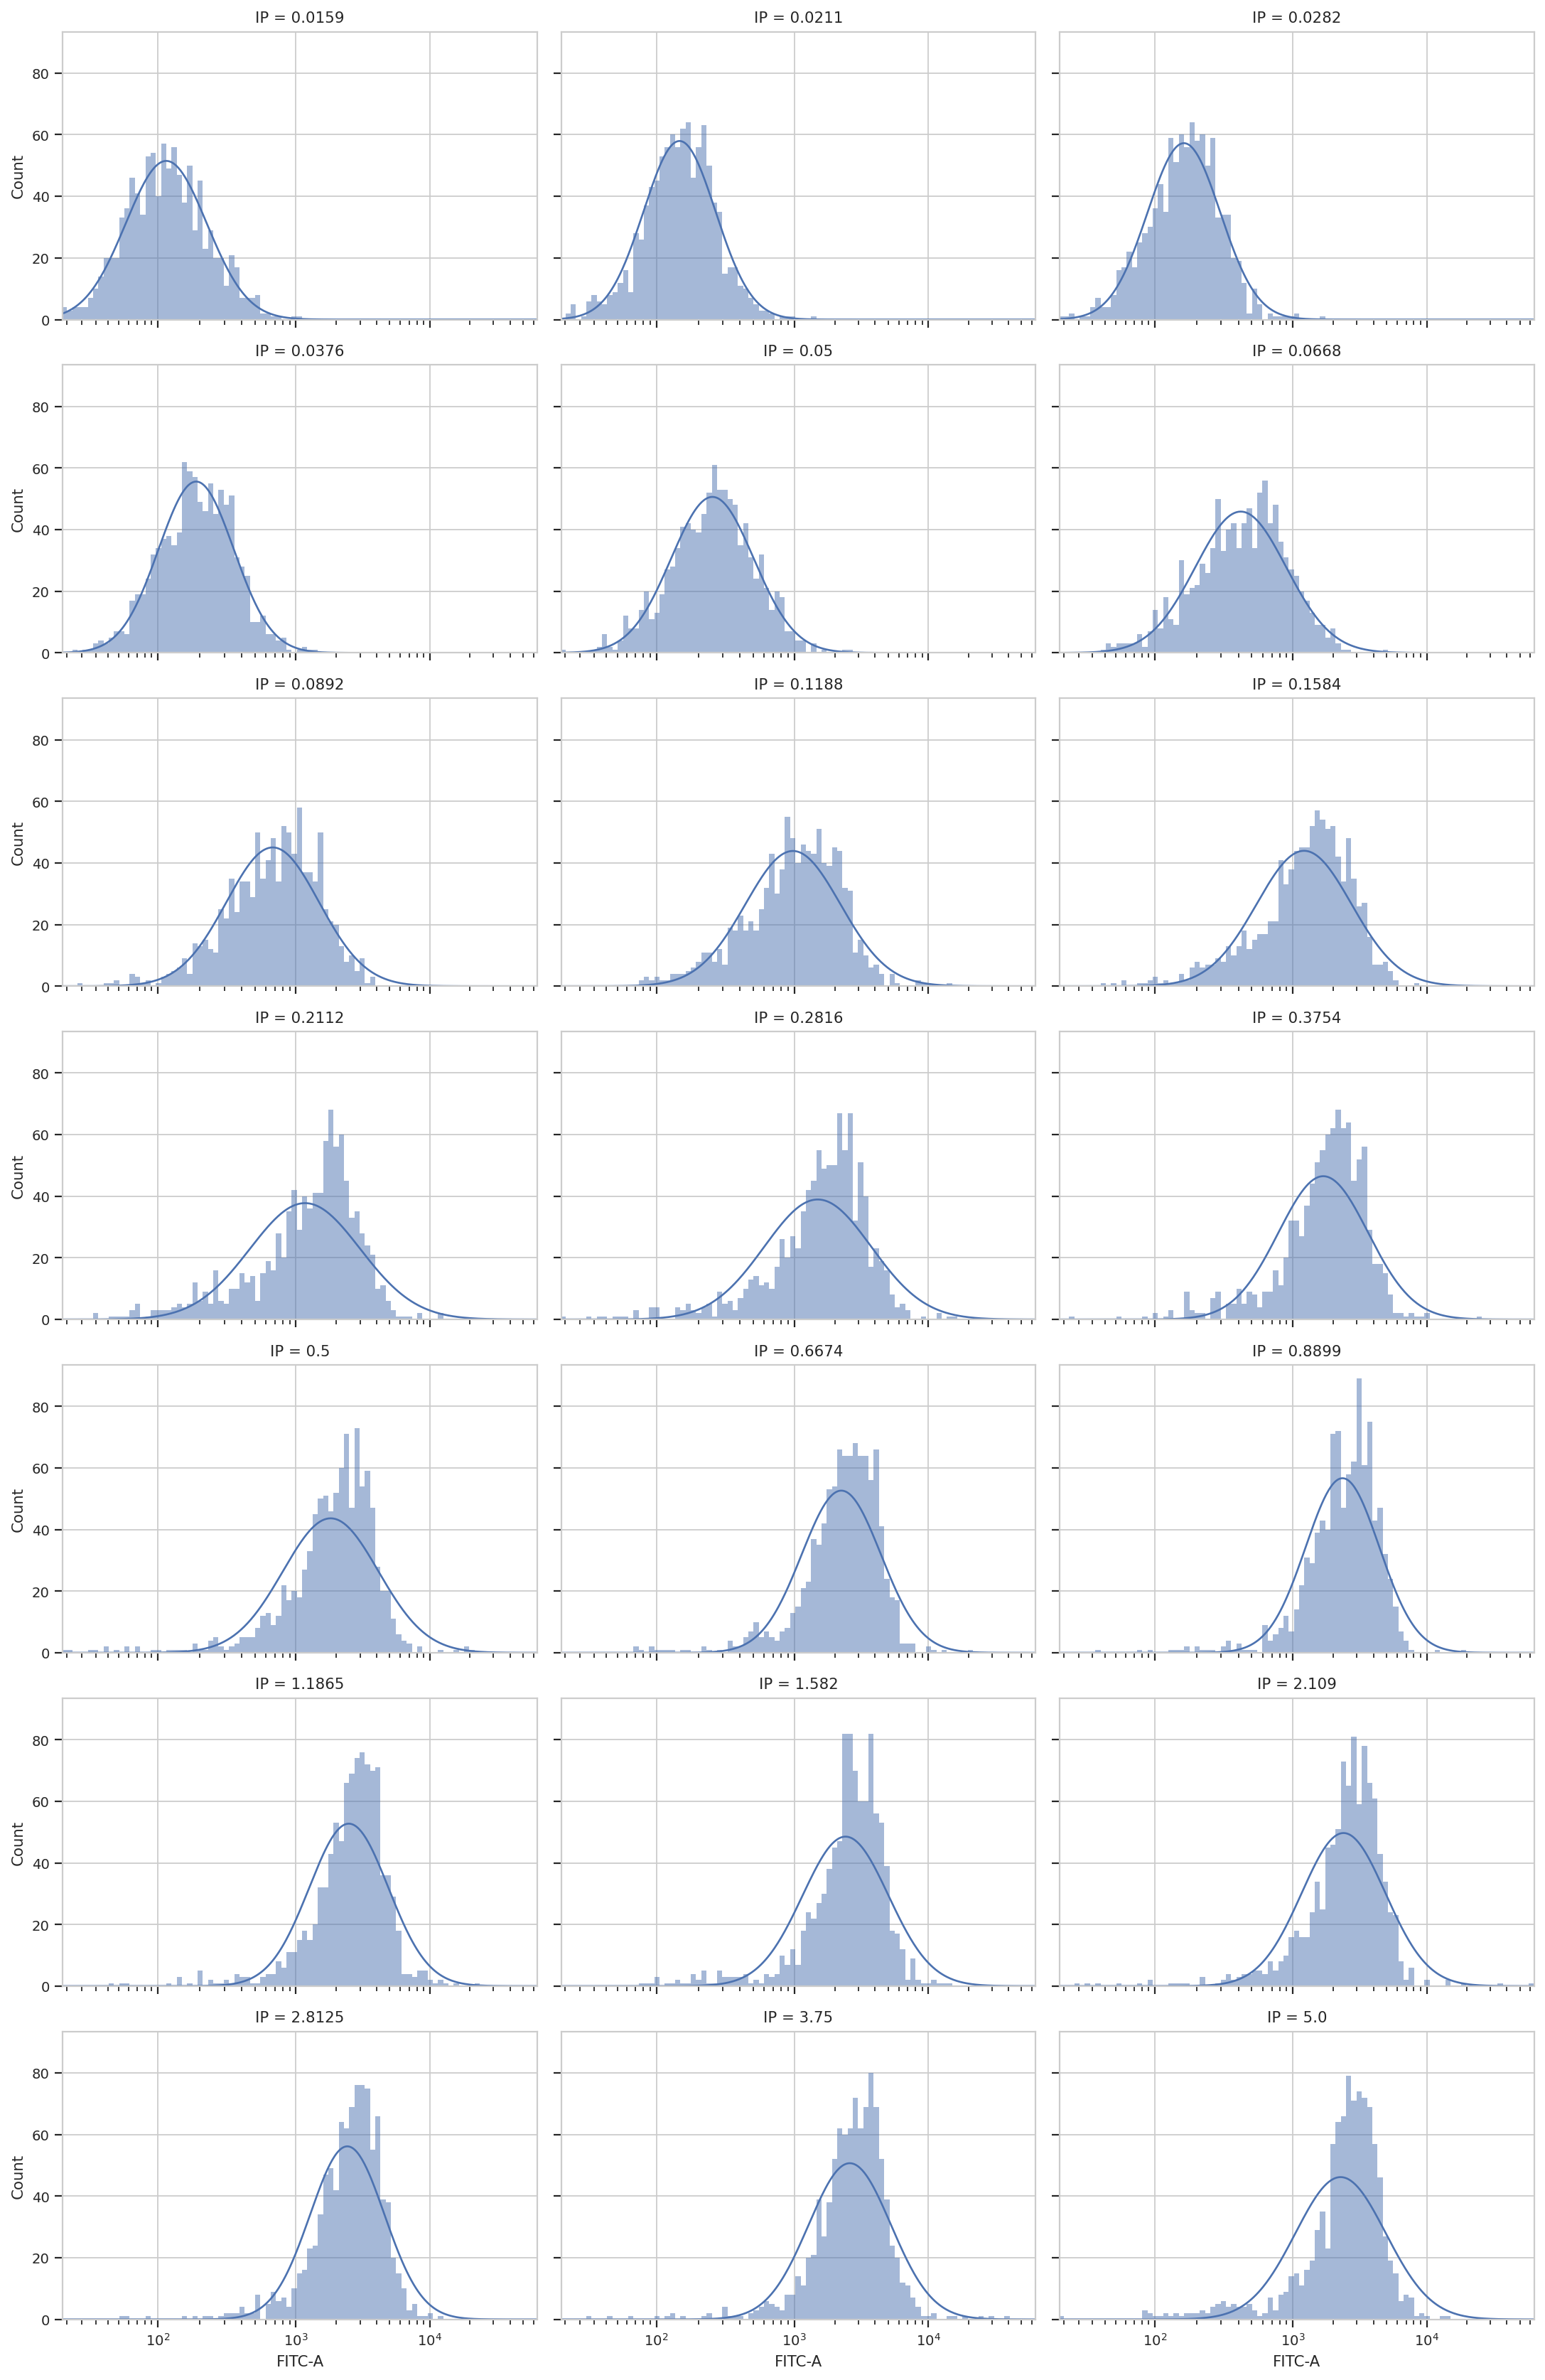

In [20]:
op.default_view(xfacet = "IP").plot(ex2, col_wrap = 3)

Let's plot the mean as it varies with IP concentration, along with the interval +/- one standard deviation:

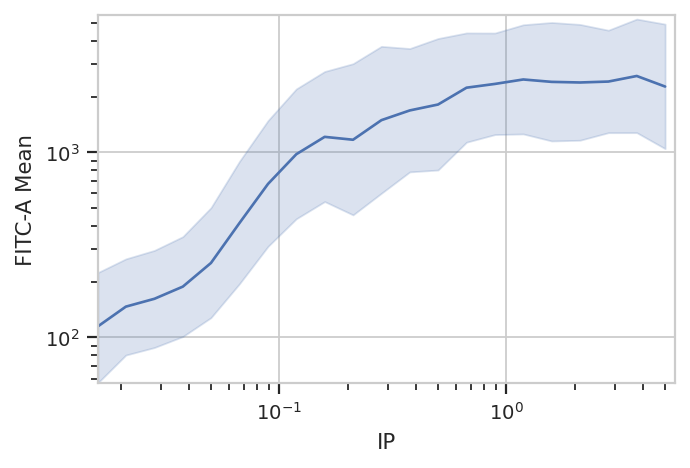

In [21]:
flow.Stats1DView(statistic = "Gauss",
                 feature = "FITC-A Mean",
                 variable = "IP",
                 variable_scale = "log",
                 scale = "log",
                 error_low = "FITC-A Interval Low",
                 error_high = "FITC-A Interval High").plot(ex2, shade_error = True)